# TD3

twin delayed DDPG

# 导入库

In [2]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import rl_utils
import os
import time

# 网络

In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # 这里直接缩放并输出, 而非像PPO中输出均值方差再采样
        return torch.tanh(self.fc2(x)) * self.action_bound  # 缩放到动作空间


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

# TD3算法

In [4]:
from numpy import dtype, ndarray


class TD3:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_space, sigma, policy_noise, 
                 noise_clip, actor_lr, critic_lr, tau, gamma, policy_freq, device, training=True):

        # * 其他参数
        self.training = training  # 是否在训练, 如果要测试则改False
        self.action_space = action_space
        self.action_dim = action_dim
        self.sample_count = 0  # 用于计数更新次数, 确定演员更新时间

        self.sigma = sigma  # 高斯噪声的标准差, 均值直接设为0
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        
        self.tau = tau  # 目标网络软更新参数
        self.gamma = gamma  # target学习率
        self.policy_freq = policy_freq  # 目标网络更新频率
        self.device = device

        self.action_scale = torch.tensor((self.action_space.high - self.action_space.low) / 2,
                                         device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        # * 技巧1: 给了两个critic Q函数, 给出较小Q值的会纳入Q_target计算
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, self.action_space.high[0]).to(device)
        self.critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)

        self.target_actor = PolicyNet(
            state_dim, hidden_dim, action_dim, self.action_space.high[0]).to(device)
        self.target_critic_1 = QValueNet(
            state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_2 = QValueNet(
            state_dim, hidden_dim, action_dim).to(device)

        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        # 设定优化器
        self.actor_optimizer = torch.optim.Adam(
            self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(
            self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(
            self.critic_2.parameters(), lr=critic_lr)

    def take_action(self, state) -> list:
        self.sample_count += 1
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        if self.training:
            # 给动作添加噪声, 增加探索, 加上裁剪
            action = action + self.sigma * np.random.randn(self.action_dim)
            action = action.clip(self.action_space.low[0], self.action_space.high[0])
        action = list(action)
        return action

    def soft_update(self, net, target_net):
        '''将target_net往net方向软更新, 每次更新幅度都很小

        参数说明
        ----------
        net : torch.nn.module
        target_net : torch.nn.module
        '''
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(
                param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict: dict):
        states = torch.tensor(
            transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(
            transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(
            transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(
            transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(
            transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(
            transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)

        # 评论员还是时序差分更新, 但这次评论员鼠鼠变成Q网络了, 需要输入状态和动作, 动作由演员选择
        # * 技巧3: 平滑动作计算, 加入了噪声的目标动作
        noise = (torch.randn_like(actions) * self.policy_noise)  # 构造加入目标动作的噪声, rand_like保持shape
        noise = noise.clip(-self.noise_clip, self.noise_clip)  # 裁剪噪声避免过大
        next_action = (self.target_actor(next_states) + noise).clamp(-self.action_scale, self.action_scale)
        target_q1 = self.target_critic_1(next_states, next_action).detach()
        target_q2 = self.target_critic_2(next_states, next_action).detach()
        # 取两个网络较小值
        next_q_values = torch.min(target_q1, target_q2)
        q_targets = rewards + self.gamma * next_q_values * (1 - (dones | truncated))

        # 两个评论员梯度下降
        critic_loss_1 = torch.mean(F.mse_loss(
            self.critic_1(states, actions), q_targets))
        critic_loss_2 = torch.mean(F.mse_loss(
            self.critic_2(states, actions), q_targets))
        self.critic_1_optimizer.zero_grad()
        self.critic_2_optimizer.zero_grad()
        critic_loss_1.backward()
        critic_loss_2.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.step()

        # * 技巧2: 延迟更新，actor的更新频率低于critic, 目标网络低于原网络
        if self.sample_count % self.policy_freq == 0:
            # 演员是梯度策略, 采用梯度上升, 加负号
            actor_loss = -torch.mean(self.critic_1(states, self.actor(states)))
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            # 演员和评论员目标网络都延迟并且软更新
            self.soft_update(self.actor, self.target_actor)
            self.soft_update(self.critic_1, self.target_critic_1)
            self.soft_update(self.critic_2, self.target_critic_2)

## ✅技巧

twin delayed DDPG

1. 第一个技巧是，采用了两个评论员网络，谁给出的目标Q值小，就用谁的Q值;

2. 第二个技巧是，目标网络需要延迟更新，在DDPG之前的案例中就已经这样操作了; 

3. 第三个技巧是，这里策略（演员）网络的更新也要延迟，策略网络更新太快会导致输出的动作很不稳定。并且更新方法采用和DDPG一样的软更新;

* 即时更新
    - 原评论员网络 `critic_1` 和 `critic_2` **直接梯度下降**

* 延迟更新
    - 原演员网络 `actor` **直接梯度下降**
    - 目标评论员网络 `target_critic_1` 和 `target_critic_2` **软更新**
    - 目标演员网络 `target_actor` **软更新**

# 参数初始化

In [5]:
# DDPG算法相关
PATH = 'checkpoints/TD3_PDv1.pt'
actor_lr = 3e-4
critic_lr = 3e-3
total_episodes = 200
total_epochs = 10
gamma = 0.98
tau = 0.005  # 软更新参数, tau越小更新幅度越小
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
policy_noise = 0.2  # 策略网络的噪声
noise_clip = 0.5  # 裁剪噪音避免过大
policy_freq = 3
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

# 环境相关
env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# 神经网络相关
state_dim = env.observation_space.shape[0]
hidden_dim = 64
action_dim = env.action_space.shape[0]
action_space = env.action_space  # 动作最大值

# 其他
agent = TD3(state_dim, hidden_dim, action_dim, action_space, sigma, policy_noise, 
            noise_clip, actor_lr, critic_lr, tau, gamma, policy_freq, device)

# 检查点函数

In [6]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic_1.load_state_dict(checkpoint['critic_1_best_weight'])
        agent.critic_2.load_state_dict(checkpoint['critic_2_best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

# 读取检查点

In [7]:
s_epoch, s_episode, return_list = read_ckp(PATH)

# 训练函数

In [ ]:
return_list = rl_utils.train_off_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, 
                                replay_buffer, minimal_size, batch_size, return_list, PATH, 3)

# 作图

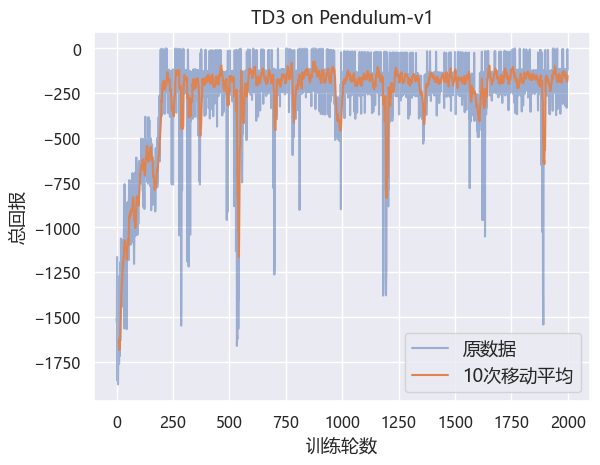

In [15]:
rl_utils.picture_return(return_list, 'TD3', env_name)

# 演示策略

-152.681


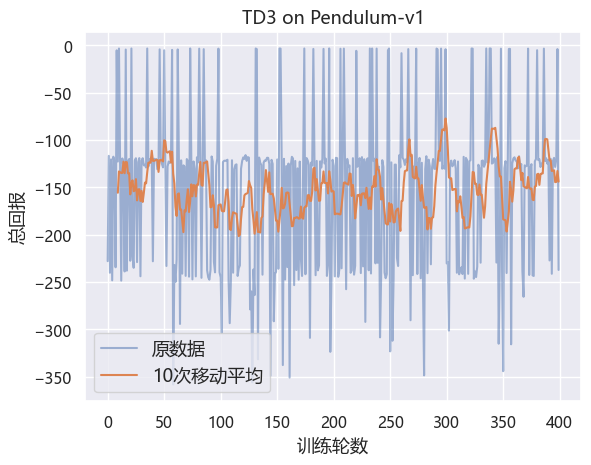

In [16]:
test_list = rl_utils.show_gym_policy(env_name, agent, 'rgb_array', epochs=400, model_type='AC', if_return=True)